# DCGAN - Wasserstein GAN Gradient Penalties
## 原文'Improved Training of Wasserstein GANs'

WGAN-GP的 $D$ 的输出是无限制的，除非通过激活函数传递。

WGAN GP在判别器 $D$ 增加了一个梯度惩罚（Gradient Penalties）的损失，作为加强Lipschitz约束的另一种方法(以前是WGAN通过权值裁剪来实现的)。这种惩罚并不会因重量剪裁而使鉴别器偏向于简单的功能。

此外，通过增加一个梯度惩罚项对该鉴别器进行重新设计，BatchNrom变得没有必要。
这点非常关键！因为批处理规范化隐式地将鉴别器的问题从一对一映射到多对多。

# Import Necessary Packages
有一说一这个DCGAN真的太难训练了啊
我使用的Trick
- ONE-SIDE Soft label
- 数据的均值和标准差不能用实际的值，而是要用0.5 why？
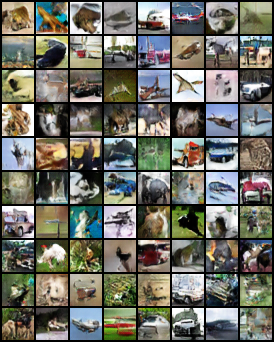


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"
import random

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets
from torchvision import transforms # 张量变换
from torchvision.utils import save_image # 保存图片

import numpy as np

from itertools import product # draw 10 * 10 images
from tqdm import tqdm

import matplotlib.pyplot as plt
# Enable Jupyter notebook plotting
%matplotlib inline

# Pytorch Version
print(torch.__version__)
print(torch.cuda.is_available())

1.7.0
True


# Hyper Parameters

In [2]:
cudnn.benchmark = True

#set manual seed to a constant get a consistent output
manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

batch_size = 128
num_epoch = 100

LAMBDA = 50 # Gradient Penalties


ngf = 64  # base dimesion of G's feature
ndf = 64 # base dimesion of D's feature
z_dim = 100 # size of input noise's channel

nc = 3 # channels of output images

lr_G = 1e-4
lr_D = 4e-4 # leanring rate of Generator and Discriminator


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Random Seed:  7392
cuda:0


# Datasets files & utils

In [3]:
# the path we save data
if not os.path.exists('../../img'):
    os.mkdir('../../img')

# Transform of our datasets
trans = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                       ])
    
# CIFAR10 datasets downloading……
cifar10 = datasets.CIFAR10(
    root = '../../data/cifar10/', train = True, transform = trans, download = True
)

# Dataloader
dataloader = torch.utils.data.DataLoader(
    dataset = cifar10, batch_size = batch_size, shuffle = True, num_workers = 8,
)



Files already downloaded and verified


In [4]:
inv_normalize = transforms.Normalize(
    mean=[-0.5/0.5, -0.5/0.5, -0.5/0.5],
    std=[1/0.5, 1/0.5, 1/0.5]
)
# inv_tensor = inv_normalize(tensor)



# Discriminator(Critic) Definitions (Wasserstein DCGAN Fashion)
 Critic (not trained to classify). 
 
- 输入一张图片
- 输出是近似真实图片与 $z\sim P(G(z))$ 的近似 Wasserstein 距离 output is the approximate Wasserstein Distance between $z\sim P(G(z))$ and real.

由于计算梯度惩罚的原因，不能使用BN
最后加了一个Relu做输出

## D的loss
$-E[D(x)] + E[D(G(z))] + λE[(||∇ D(εx + (1 − εG(z)))|| - 1)^2]$

It is a **unconditional** version.

In [5]:

class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.D = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(nc, ndf, kernel_size = 4,
                      stride = 2, padding = 1),
            nn.InstanceNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
        )

    
    def forward(self, x):
        x = self.D(x)
        return x

# Generator Definitions (Vanilla DCGAN Fashion)
The generator, $G$, is designed to map the latent space vector $(z)$ to data-space. Since our data are images, converting z to data-space means ultimately creating a RGB image with the same size as the training images (i.e. 3x64x64). In practice, this is accomplished through a series of strided two dimensional convolutional transpose layers, each paired with a 2d batch norm layer and a relu activation. The output of the generator is fed through a tanh function to return it to the input data range of $[−1,1]$. It is worth noting the existence of the batch norm functions after the conv-transpose layers, as this is a critical contribution of the DCGAN paper. These layers help with the flow of gradients during training. An image of the generator from the DCGAN paper is shown below.

The generator, G, is designed to map the latent space vector $(z)$ to data-space. Since our data are images, converting z to data-space means ultimately creating a RGB image with the same size as the training images (i.e. 3x64x64). In practice, this is accomplished through a series of strided two dimensional convolutional transpose layers, each paired with a 2d batch norm layer and a relu activation. The output of the generator is fed through a tanh function to return it to the input data range of $[−1,1]$. It is worth noting the existence of the batch norm functions after the conv-transpose layers, as this is a critical contribution of the DCGAN paper. These layers help with the flow of gradients during training. An image of the generator from the DCGAN paper is shown below.

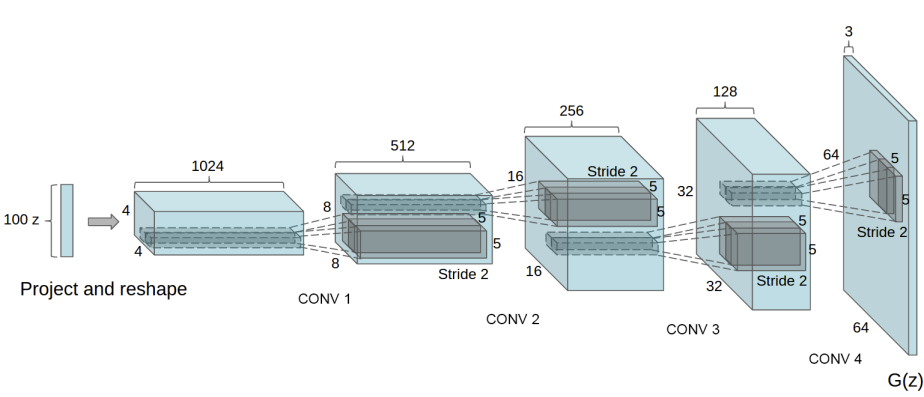

The final `Tanh` activataion function can project output into (-1,1)

Notice, the how the inputs we set in the input section (nz, ngf, and nc) influence the generator architecture in code. nz is the length of the z input vector, ngf relates to the size of the feature maps that are propagated through the generator, and nc is the number of channels in the output image (set to 3 for RGB images). Below is the code for the generator.


It is a **unconditional** version.

In [6]:

class generator(nn.Module):
    
    def __init__(self):
        super(generator, self).__init__()
        self.G = nn.Sequential(
            nn.ConvTranspose2d(z_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=4,
                              stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            
            nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=4,
                              stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, nc, kernel_size=4,
                              stride=2, padding=1, bias=False),
            # state size. nc x 32 x 32            
            nn.Tanh()
            )
        
    def forward(self, x):
        x = self.G(x)
        return x
        
        

## Weight Initialization
From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. The weights_init function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function is applied to the models immediately after initialization.

WGAN并没有说明要不要初始化来着，先留着看看


In [7]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Traning Phase
## Model & Opitmizer

In [8]:


D = discriminator()
G = generator()
D.apply(weights_init)
G.apply(weights_init)
# TODO: 自定义初始化

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

D = D.to(device)
G = G.to(device)




In [9]:

d_optimizer = torch.optim.Adam(D.parameters(), lr = lr_D, betas=(0.5,0.9))
g_optimizer = torch.optim.Adam(G.parameters(), lr = lr_G, betas=(0.5,0.9))

## Trainning Start!

  0%|          | 0/100 [00:00<?, ?it/s]

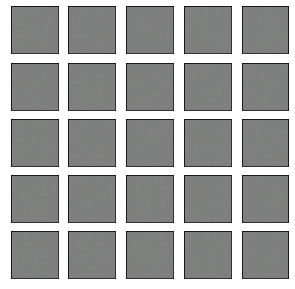

Epoch[0/100],d_loss:36.628128,g_loss:1.451290 D real: -0.007150,D fake: -1.451290, Grad_Norm: 0.456682
Epoch[0/100],d_loss:-63.433609,g_loss:39.750069 D real: 44.838051,D fake: -39.750069, Grad_Norm: 0.923804
Epoch[0/100],d_loss:-157.569794,g_loss:121.458618 D real: 103.677643,D fake: -121.458618, Grad_Norm: 1.234120
Epoch[0/100],d_loss:-243.502777,g_loss:184.775665 D real: 165.778015,D fake: -184.775665, Grad_Norm: 1.509836


  1%|          | 1/100 [00:28<47:26, 28.75s/it]

Epoch[1/100],d_loss:-298.617096,g_loss:219.243805 D real: 173.872299,D fake: -219.243805, Grad_Norm: 1.585052
Epoch[1/100],d_loss:-389.451050,g_loss:276.597260 D real: 196.279816,D fake: -276.597260, Grad_Norm: 1.615803
Epoch[1/100],d_loss:-437.351715,g_loss:349.392944 D real: 282.978943,D fake: -349.392944, Grad_Norm: 1.835933
Epoch[1/100],d_loss:-363.075684,g_loss:278.666382 D real: 237.588379,D fake: -278.666382, Grad_Norm: 2.062441


  2%|▏         | 2/100 [00:55<46:00, 28.17s/it]

Epoch[2/100],d_loss:-214.304688,g_loss:232.446625 D real: 146.750946,D fake: -232.446625, Grad_Norm: 2.037092
Epoch[2/100],d_loss:-180.372772,g_loss:215.883484 D real: 137.806519,D fake: -215.883484, Grad_Norm: 1.972359
Epoch[2/100],d_loss:-251.856293,g_loss:283.756653 D real: 131.711792,D fake: -283.756653, Grad_Norm: 1.897619
Epoch[2/100],d_loss:-266.427185,g_loss:212.962708 D real: 176.587921,D fake: -212.962708, Grad_Norm: 1.792828


  3%|▎         | 3/100 [01:24<45:42, 28.28s/it]

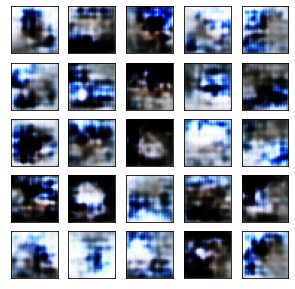

Epoch[3/100],d_loss:-234.016479,g_loss:292.231628 D real: 85.605186,D fake: -292.231628, Grad_Norm: 1.899657
Epoch[3/100],d_loss:-310.273438,g_loss:248.211151 D real: 206.948975,D fake: -248.211151, Grad_Norm: 2.163280
Epoch[3/100],d_loss:-333.851135,g_loss:270.273315 D real: 229.960922,D fake: -270.273315, Grad_Norm: 2.084858
Epoch[3/100],d_loss:-223.738098,g_loss:199.864594 D real: 209.824554,D fake: -199.864594, Grad_Norm: 2.122769


  4%|▍         | 4/100 [01:51<44:36, 27.88s/it]

Epoch[4/100],d_loss:-225.038574,g_loss:241.498444 D real: 128.651031,D fake: -241.498444, Grad_Norm: 1.921638
Epoch[4/100],d_loss:-320.003387,g_loss:238.145493 D real: 245.513550,D fake: -238.145493, Grad_Norm: 2.098367
Epoch[4/100],d_loss:-242.319901,g_loss:250.686188 D real: 114.438095,D fake: -250.686188, Grad_Norm: 1.927700
Epoch[4/100],d_loss:-257.541870,g_loss:302.125763 D real: 90.801308,D fake: -302.125763, Grad_Norm: 1.895731


  5%|▌         | 5/100 [02:17<43:22, 27.40s/it]

Epoch[5/100],d_loss:-236.961853,g_loss:66.165802 D real: 245.487030,D fake: -66.165802, Grad_Norm: 1.634305
Epoch[5/100],d_loss:-220.440735,g_loss:230.937683 D real: 97.763596,D fake: -230.937683, Grad_Norm: 1.798246
Epoch[5/100],d_loss:-134.607193,g_loss:147.821503 D real: 104.854065,D fake: -147.821503, Grad_Norm: 1.730051
Epoch[5/100],d_loss:-206.625641,g_loss:139.644318 D real: 168.981934,D fake: -139.644318, Grad_Norm: 1.596707


  6%|▌         | 6/100 [02:43<42:27, 27.10s/it]

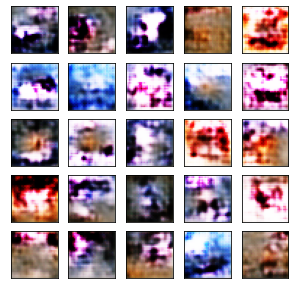

Epoch[6/100],d_loss:-181.922394,g_loss:192.109100 D real: 104.334015,D fake: -192.109100, Grad_Norm: 1.618098
Epoch[6/100],d_loss:-143.990982,g_loss:113.193466 D real: 122.160797,D fake: -113.193466, Grad_Norm: 1.530991
Epoch[6/100],d_loss:-139.800964,g_loss:107.260963 D real: 124.618454,D fake: -107.260963, Grad_Norm: 1.442926
Epoch[6/100],d_loss:-115.743729,g_loss:44.135220 D real: 129.400787,D fake: -44.135220, Grad_Norm: 1.514991


  7%|▋         | 7/100 [03:11<42:18, 27.29s/it]

Epoch[7/100],d_loss:-92.005905,g_loss:52.658405 D real: 120.450005,D fake: -52.658405, Grad_Norm: 1.504421
Epoch[7/100],d_loss:-140.899033,g_loss:120.615395 D real: 115.163101,D fake: -120.615395, Grad_Norm: 1.612976
Epoch[7/100],d_loss:-155.299866,g_loss:106.284554 D real: 98.361534,D fake: -106.284554, Grad_Norm: 1.482170
Epoch[7/100],d_loss:-112.231049,g_loss:119.174980 D real: 81.664200,D fake: -119.174980, Grad_Norm: 1.529436


  8%|▊         | 8/100 [03:39<42:08, 27.49s/it]

Epoch[8/100],d_loss:-81.404312,g_loss:54.401634 D real: 92.024895,D fake: -54.401634, Grad_Norm: 1.528469
Epoch[8/100],d_loss:-96.176788,g_loss:49.442272 D real: 99.684052,D fake: -49.442272, Grad_Norm: 1.491360
Epoch[8/100],d_loss:-121.077423,g_loss:59.351379 D real: 115.081833,D fake: -59.351379, Grad_Norm: 1.464396
Epoch[8/100],d_loss:-106.777641,g_loss:61.044670 D real: 101.442520,D fake: -61.044670, Grad_Norm: 1.371808


  9%|▉         | 9/100 [04:08<42:21, 27.93s/it]

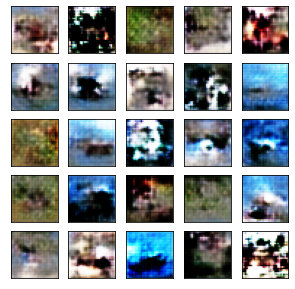

Epoch[9/100],d_loss:-90.855423,g_loss:67.787109 D real: 93.464340,D fake: -67.787109, Grad_Norm: 1.390019
Epoch[9/100],d_loss:-98.778389,g_loss:73.470802 D real: 83.405228,D fake: -73.470802, Grad_Norm: 1.478287
Epoch[9/100],d_loss:-93.790916,g_loss:53.100727 D real: 109.183914,D fake: -53.100727, Grad_Norm: 1.379428
Epoch[9/100],d_loss:-107.338570,g_loss:60.854271 D real: 98.262794,D fake: -60.854271, Grad_Norm: 1.444992


 10%|█         | 10/100 [04:36<41:50, 27.89s/it]

Epoch[10/100],d_loss:-95.898399,g_loss:47.378880 D real: 122.781799,D fake: -47.378880, Grad_Norm: 1.415738
Epoch[10/100],d_loss:-61.771843,g_loss:27.908321 D real: 94.051346,D fake: -27.908321, Grad_Norm: 1.374576
Epoch[10/100],d_loss:-84.772263,g_loss:29.045572 D real: 120.923920,D fake: -29.045572, Grad_Norm: 1.400616
Epoch[10/100],d_loss:-86.451454,g_loss:79.298286 D real: 55.641022,D fake: -79.298286, Grad_Norm: 1.369205


 11%|█         | 11/100 [05:02<40:52, 27.56s/it]

Epoch[11/100],d_loss:-71.515930,g_loss:38.205963 D real: 106.002960,D fake: -38.205963, Grad_Norm: 1.465428
Epoch[11/100],d_loss:-90.037849,g_loss:66.813911 D real: 79.233849,D fake: -66.813911, Grad_Norm: 1.397026
Epoch[11/100],d_loss:-67.899063,g_loss:46.797665 D real: 71.167625,D fake: -46.797665, Grad_Norm: 1.335989
Epoch[11/100],d_loss:-88.487511,g_loss:87.633690 D real: 35.949490,D fake: -87.633690, Grad_Norm: 1.327737


 12%|█▏        | 12/100 [05:27<39:09, 26.70s/it]

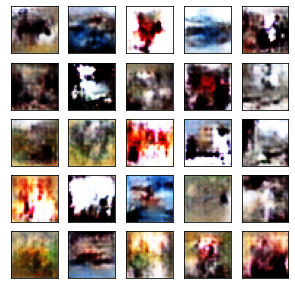

Epoch[12/100],d_loss:-71.924377,g_loss:51.582832 D real: 73.924011,D fake: -51.582832, Grad_Norm: 1.341732
Epoch[12/100],d_loss:-71.569832,g_loss:25.788452 D real: 111.334335,D fake: -25.788452, Grad_Norm: 1.382058
Epoch[12/100],d_loss:-68.191368,g_loss:34.343288 D real: 72.420937,D fake: -34.343288, Grad_Norm: 1.249061
Epoch[12/100],d_loss:-71.363770,g_loss:45.002720 D real: 61.052063,D fake: -45.002720, Grad_Norm: 1.226161


 13%|█▎        | 13/100 [05:56<39:31, 27.26s/it]

Epoch[13/100],d_loss:-72.624298,g_loss:44.203995 D real: 56.151699,D fake: -44.203995, Grad_Norm: 1.230219
Epoch[13/100],d_loss:-58.652267,g_loss:75.662170 D real: 46.445473,D fake: -75.662170, Grad_Norm: 1.344737
Epoch[13/100],d_loss:-92.088020,g_loss:60.339905 D real: 74.990578,D fake: -60.339905, Grad_Norm: 1.277793
Epoch[13/100],d_loss:-48.643906,g_loss:37.668533 D real: 49.743847,D fake: -37.668533, Grad_Norm: 1.279668


 14%|█▍        | 14/100 [06:21<38:18, 26.73s/it]

Epoch[14/100],d_loss:-44.607174,g_loss:34.730637 D real: 40.172298,D fake: -34.730637, Grad_Norm: 1.162514
Epoch[14/100],d_loss:-50.549042,g_loss:16.425686 D real: 58.552536,D fake: -16.425686, Grad_Norm: 1.159287
Epoch[14/100],d_loss:-43.480667,g_loss:32.524677 D real: 38.198547,D fake: -32.524677, Grad_Norm: 1.165158
Epoch[14/100],d_loss:-39.636955,g_loss:46.003368 D real: 54.126514,D fake: -46.003368, Grad_Norm: 1.218565


 15%|█▌        | 15/100 [06:48<38:03, 26.87s/it]

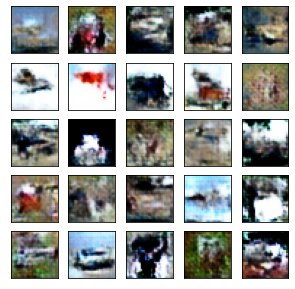

Epoch[15/100],d_loss:-68.745697,g_loss:59.478592 D real: 45.616310,D fake: -59.478592, Grad_Norm: 1.146653
Epoch[15/100],d_loss:-44.204323,g_loss:-2.486196 D real: 90.682594,D fake: 2.486196, Grad_Norm: 1.263175
Epoch[15/100],d_loss:-50.306709,g_loss:44.935722 D real: 46.267990,D fake: -44.935722, Grad_Norm: 1.196061
Epoch[15/100],d_loss:-19.766926,g_loss:26.954262 D real: 32.214668,D fake: -26.954262, Grad_Norm: 1.203444


 16%|█▌        | 16/100 [07:17<38:27, 27.47s/it]

Epoch[16/100],d_loss:-47.339676,g_loss:-12.537327 D real: 76.768448,D fake: 12.537327, Grad_Norm: 1.137116
Epoch[16/100],d_loss:-46.381847,g_loss:50.624058 D real: 29.312511,D fake: -50.624058, Grad_Norm: 1.173795
Epoch[16/100],d_loss:-53.774498,g_loss:44.007820 D real: 46.508461,D fake: -44.007820, Grad_Norm: 1.204799
Epoch[16/100],d_loss:-49.951263,g_loss:5.049637 D real: 68.833511,D fake: -5.049637, Grad_Norm: 1.038989


 17%|█▋        | 17/100 [07:45<38:00, 27.48s/it]

Epoch[17/100],d_loss:-30.764767,g_loss:33.768520 D real: 25.420063,D fake: -33.768520, Grad_Norm: 1.140036
Epoch[17/100],d_loss:-33.334541,g_loss:12.279680 D real: 54.062721,D fake: -12.279680, Grad_Norm: 1.125346
Epoch[17/100],d_loss:-34.778900,g_loss:46.710800 D real: 13.154085,D fake: -46.710800, Grad_Norm: 1.126779
Epoch[17/100],d_loss:-49.546242,g_loss:6.766328 D real: 68.077850,D fake: -6.766328, Grad_Norm: 1.120420


 18%|█▊        | 18/100 [08:12<37:19, 27.31s/it]

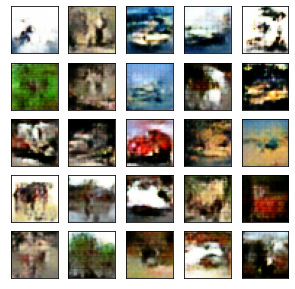

Epoch[18/100],d_loss:-35.444107,g_loss:-6.304517 D real: 75.566727,D fake: 6.304517, Grad_Norm: 1.224491
Epoch[18/100],d_loss:-36.466286,g_loss:58.980392 D real: 7.943228,D fake: -58.980392, Grad_Norm: 1.140649
Epoch[18/100],d_loss:-27.555515,g_loss:38.986813 D real: 30.100895,D fake: -38.986813, Grad_Norm: 1.150912
Epoch[18/100],d_loss:-43.946732,g_loss:62.866474 D real: 6.895363,D fake: -62.866474, Grad_Norm: 1.128588


 19%|█▉        | 19/100 [08:40<37:08, 27.51s/it]

Epoch[19/100],d_loss:-36.798187,g_loss:53.694664 D real: 7.605518,D fake: -53.694664, Grad_Norm: 1.123632
Epoch[19/100],d_loss:-37.834610,g_loss:37.896881 D real: 33.489502,D fake: -37.896881, Grad_Norm: 1.104645
Epoch[19/100],d_loss:-39.044174,g_loss:38.086933 D real: 34.909100,D fake: -38.086933, Grad_Norm: 1.122433
Epoch[19/100],d_loss:-34.634041,g_loss:15.550227 D real: 41.427650,D fake: -15.550227, Grad_Norm: 1.132435


 20%|██        | 20/100 [09:06<36:12, 27.16s/it]

Epoch[20/100],d_loss:-28.150442,g_loss:31.029234 D real: 22.488880,D fake: -31.029234, Grad_Norm: 1.135564
Epoch[20/100],d_loss:-26.132837,g_loss:56.164417 D real: 8.845911,D fake: -56.164417, Grad_Norm: 1.103450
Epoch[20/100],d_loss:-41.610626,g_loss:58.437813 D real: 17.105289,D fake: -58.437813, Grad_Norm: 1.091448
Epoch[20/100],d_loss:-38.206032,g_loss:64.927841 D real: -0.575652,D fake: -64.927841, Grad_Norm: 1.143489


 21%|██        | 21/100 [09:32<35:13, 26.75s/it]

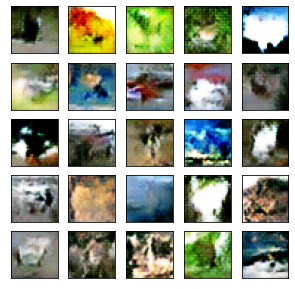

Epoch[21/100],d_loss:-25.526127,g_loss:28.903534 D real: 31.819466,D fake: -28.903534, Grad_Norm: 1.110835
Epoch[21/100],d_loss:-37.868477,g_loss:27.427130 D real: 36.776939,D fake: -27.427130, Grad_Norm: 1.051748
Epoch[21/100],d_loss:-23.258183,g_loss:29.515110 D real: 17.243832,D fake: -29.515110, Grad_Norm: 1.131912
Epoch[21/100],d_loss:-27.345343,g_loss:75.231918 D real: -8.908750,D fake: -75.231918, Grad_Norm: 1.085009


 22%|██▏       | 22/100 [09:59<34:59, 26.92s/it]

Epoch[22/100],d_loss:-12.946774,g_loss:25.225334 D real: 22.575760,D fake: -25.225334, Grad_Norm: 1.074956
Epoch[22/100],d_loss:-35.606514,g_loss:28.785973 D real: 28.938457,D fake: -28.785973, Grad_Norm: 1.115072
Epoch[22/100],d_loss:-26.233570,g_loss:32.277622 D real: 19.136246,D fake: -32.277622, Grad_Norm: 1.065350
Epoch[22/100],d_loss:-30.069969,g_loss:41.540222 D real: 12.300144,D fake: -41.540222, Grad_Norm: 1.091897


 23%|██▎       | 23/100 [10:26<34:31, 26.91s/it]

Epoch[23/100],d_loss:-26.132748,g_loss:46.003815 D real: 8.652887,D fake: -46.003815, Grad_Norm: 1.107875
Epoch[23/100],d_loss:-19.890305,g_loss:39.042362 D real: 14.177676,D fake: -39.042362, Grad_Norm: 1.125472
Epoch[23/100],d_loss:-33.069359,g_loss:64.918724 D real: -4.283869,D fake: -64.918724, Grad_Norm: 1.096191
Epoch[23/100],d_loss:-23.626007,g_loss:45.677956 D real: 6.682825,D fake: -45.677956, Grad_Norm: 1.045015


 24%|██▍       | 24/100 [10:52<33:34, 26.51s/it]

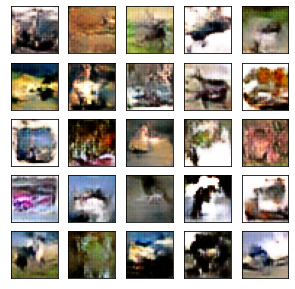

Epoch[24/100],d_loss:-29.147085,g_loss:44.381432 D real: 8.934062,D fake: -44.381432, Grad_Norm: 1.121831
Epoch[24/100],d_loss:-36.604599,g_loss:46.022602 D real: 12.285639,D fake: -46.022602, Grad_Norm: 1.041094
Epoch[24/100],d_loss:-33.892319,g_loss:47.455524 D real: 18.929703,D fake: -47.455524, Grad_Norm: 1.036961
Epoch[24/100],d_loss:-32.658154,g_loss:39.058449 D real: 14.900494,D fake: -39.058449, Grad_Norm: 1.032788


 25%|██▌       | 25/100 [11:21<34:23, 27.52s/it]

Epoch[25/100],d_loss:-30.428974,g_loss:40.016895 D real: 13.459440,D fake: -40.016895, Grad_Norm: 1.033945
Epoch[25/100],d_loss:-33.754520,g_loss:68.141769 D real: -12.272484,D fake: -68.141769, Grad_Norm: 1.132699
Epoch[25/100],d_loss:-31.599854,g_loss:34.305611 D real: 26.244064,D fake: -34.305611, Grad_Norm: 1.118514
Epoch[25/100],d_loss:-24.209063,g_loss:60.839458 D real: -7.003573,D fake: -60.839458, Grad_Norm: 1.041390


 26%|██▌       | 26/100 [11:49<34:00, 27.57s/it]

Epoch[26/100],d_loss:-30.896315,g_loss:59.410175 D real: 2.216918,D fake: -59.410175, Grad_Norm: 1.080210
Epoch[26/100],d_loss:-10.821541,g_loss:57.968521 D real: -10.433613,D fake: -57.968521, Grad_Norm: 1.062529
Epoch[26/100],d_loss:-40.178085,g_loss:49.397182 D real: 11.596219,D fake: -49.397182, Grad_Norm: 1.075814
Epoch[26/100],d_loss:-18.653786,g_loss:62.127991 D real: -17.990541,D fake: -62.127991, Grad_Norm: 1.104101


 27%|██▋       | 27/100 [12:12<31:52, 26.19s/it]

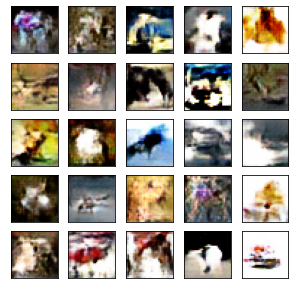

Epoch[27/100],d_loss:-27.938549,g_loss:28.005793 D real: 19.924326,D fake: -28.005793, Grad_Norm: 1.023239
Epoch[27/100],d_loss:-14.453878,g_loss:23.833199 D real: 26.223232,D fake: -23.833199, Grad_Norm: 1.064823
Epoch[27/100],d_loss:-12.966179,g_loss:18.890259 D real: 31.376545,D fake: -18.890259, Grad_Norm: 1.100206
Epoch[27/100],d_loss:-17.594315,g_loss:48.707088 D real: -5.985518,D fake: -48.707088, Grad_Norm: 1.081673


 28%|██▊       | 28/100 [12:40<31:51, 26.55s/it]

Epoch[28/100],d_loss:-27.890511,g_loss:39.726845 D real: 19.816050,D fake: -39.726845, Grad_Norm: 1.067028
Epoch[28/100],d_loss:-23.816168,g_loss:94.450485 D real: -42.458481,D fake: -94.450485, Grad_Norm: 1.097651
Epoch[28/100],d_loss:-17.870825,g_loss:45.734684 D real: -7.767856,D fake: -45.734684, Grad_Norm: 1.019517
Epoch[28/100],d_loss:-25.721392,g_loss:79.104233 D real: -32.832962,D fake: -79.104233, Grad_Norm: 1.055437


 29%|██▉       | 29/100 [13:06<31:27, 26.58s/it]

Epoch[29/100],d_loss:-22.435648,g_loss:37.961311 D real: -5.964046,D fake: -37.961311, Grad_Norm: 1.036650
Epoch[29/100],d_loss:-35.788925,g_loss:54.392105 D real: -0.452524,D fake: -54.392105, Grad_Norm: 1.066328
Epoch[29/100],d_loss:-20.634682,g_loss:43.026924 D real: -9.878025,D fake: -43.026924, Grad_Norm: 1.028114
Epoch[29/100],d_loss:-8.502884,g_loss:41.341560 D real: -0.673226,D fake: -41.341560, Grad_Norm: 1.022115


 30%|███       | 30/100 [13:33<31:06, 26.67s/it]

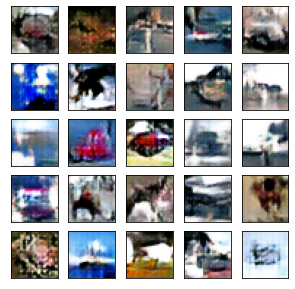

Epoch[30/100],d_loss:-25.500202,g_loss:80.862274 D real: -19.057022,D fake: -80.862274, Grad_Norm: 1.029932
Epoch[30/100],d_loss:-19.015377,g_loss:39.240761 D real: 11.803370,D fake: -39.240761, Grad_Norm: 1.071067
Epoch[30/100],d_loss:-16.884800,g_loss:60.901012 D real: -12.791945,D fake: -60.901012, Grad_Norm: 0.985369
Epoch[30/100],d_loss:-11.349037,g_loss:63.372726 D real: -25.544861,D fake: -63.372726, Grad_Norm: 1.016854


 31%|███       | 31/100 [14:04<32:08, 27.95s/it]

Epoch[31/100],d_loss:-16.213076,g_loss:25.082104 D real: 19.710358,D fake: -25.082104, Grad_Norm: 1.063203
Epoch[31/100],d_loss:-13.021915,g_loss:57.297337 D real: -2.426039,D fake: -57.297337, Grad_Norm: 1.078452
Epoch[31/100],d_loss:-13.961485,g_loss:60.161282 D real: -18.694641,D fake: -60.161282, Grad_Norm: 1.001647
Epoch[31/100],d_loss:-20.605270,g_loss:19.587521 D real: 17.958366,D fake: -19.587521, Grad_Norm: 1.030329


 32%|███▏      | 32/100 [14:29<30:39, 27.05s/it]

Epoch[32/100],d_loss:-24.907383,g_loss:71.127174 D real: -24.504457,D fake: -71.127174, Grad_Norm: 1.007744
Epoch[32/100],d_loss:-22.756739,g_loss:27.780807 D real: 11.054010,D fake: -27.780807, Grad_Norm: 0.998874
Epoch[32/100],d_loss:-12.824041,g_loss:34.195496 D real: 6.538802,D fake: -34.195496, Grad_Norm: 1.000485
Epoch[32/100],d_loss:-20.308666,g_loss:45.811653 D real: -13.825525,D fake: -45.811653, Grad_Norm: 0.981299


 33%|███▎      | 33/100 [14:54<29:42, 26.60s/it]

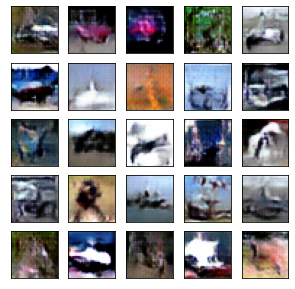

Epoch[33/100],d_loss:-22.670734,g_loss:60.683868 D real: -15.904805,D fake: -60.683868, Grad_Norm: 1.041618
Epoch[33/100],d_loss:-13.951361,g_loss:41.297432 D real: -6.771452,D fake: -41.297432, Grad_Norm: 0.943200
Epoch[33/100],d_loss:-13.457020,g_loss:45.176582 D real: -11.151782,D fake: -45.176582, Grad_Norm: 1.023776
Epoch[33/100],d_loss:-14.004497,g_loss:19.582870 D real: 13.573318,D fake: -19.582870, Grad_Norm: 1.011692


 34%|███▍      | 34/100 [15:23<30:00, 27.28s/it]

Epoch[34/100],d_loss:-17.303238,g_loss:37.138817 D real: 6.991386,D fake: -37.138817, Grad_Norm: 0.989721
Epoch[34/100],d_loss:-26.756741,g_loss:85.675522 D real: -29.203167,D fake: -85.675522, Grad_Norm: 1.057423
Epoch[34/100],d_loss:-13.779184,g_loss:62.415314 D real: -27.247482,D fake: -62.415314, Grad_Norm: 1.055886
Epoch[34/100],d_loss:-26.880356,g_loss:33.628624 D real: 12.557619,D fake: -33.628624, Grad_Norm: 1.013489


 35%|███▌      | 35/100 [15:49<29:10, 26.93s/it]

Epoch[35/100],d_loss:-19.914816,g_loss:20.642939 D real: 12.526043,D fake: -20.642939, Grad_Norm: 0.976628
Epoch[35/100],d_loss:-22.352463,g_loss:34.933830 D real: 2.353975,D fake: -34.933830, Grad_Norm: 1.013765
Epoch[35/100],d_loss:-18.809528,g_loss:19.976101 D real: 18.598400,D fake: -19.976101, Grad_Norm: 0.982917
Epoch[35/100],d_loss:-5.438812,g_loss:3.277937 D real: 30.927689,D fake: -3.277937, Grad_Norm: 0.994110


 36%|███▌      | 36/100 [16:16<28:31, 26.75s/it]

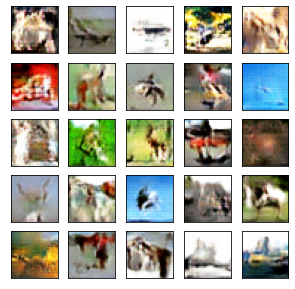

Epoch[36/100],d_loss:-9.903277,g_loss:19.235531 D real: 12.140418,D fake: -19.235531, Grad_Norm: 0.955294
Epoch[36/100],d_loss:-17.339756,g_loss:26.866993 D real: 7.639602,D fake: -26.866993, Grad_Norm: 0.939177
Epoch[36/100],d_loss:-21.057465,g_loss:56.788094 D real: -4.678523,D fake: -56.788094, Grad_Norm: 0.989180
Epoch[36/100],d_loss:-16.409718,g_loss:38.276588 D real: 0.833307,D fake: -38.276588, Grad_Norm: 0.989733


 37%|███▋      | 37/100 [16:45<29:00, 27.62s/it]

Epoch[37/100],d_loss:-26.458361,g_loss:40.089611 D real: 7.410163,D fake: -40.089611, Grad_Norm: 1.027436
Epoch[37/100],d_loss:-18.079895,g_loss:29.873711 D real: 11.158707,D fake: -29.873711, Grad_Norm: 0.981051
Epoch[37/100],d_loss:-15.158770,g_loss:-1.217508 D real: 23.035784,D fake: 1.217508, Grad_Norm: 0.959678
Epoch[37/100],d_loss:-14.908053,g_loss:6.914227 D real: 25.350803,D fake: -6.914227, Grad_Norm: 0.950840


 38%|███▊      | 38/100 [17:13<28:37, 27.71s/it]

Epoch[38/100],d_loss:-8.449417,g_loss:26.818991 D real: 5.936385,D fake: -26.818991, Grad_Norm: 1.014294
Epoch[38/100],d_loss:-9.254734,g_loss:44.985874 D real: -14.041481,D fake: -44.985874, Grad_Norm: 1.055591
Epoch[38/100],d_loss:-25.809208,g_loss:44.276459 D real: -1.582963,D fake: -44.276459, Grad_Norm: 0.945247
Epoch[38/100],d_loss:-14.904364,g_loss:37.680672 D real: 13.804468,D fake: -37.680672, Grad_Norm: 1.014305


 39%|███▉      | 39/100 [17:41<28:06, 27.65s/it]

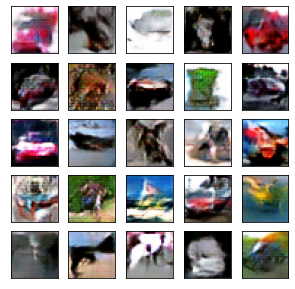

Epoch[39/100],d_loss:-18.205652,g_loss:29.309793 D real: 5.668432,D fake: -29.309793, Grad_Norm: 1.016039
Epoch[39/100],d_loss:-29.139282,g_loss:24.549122 D real: 19.954090,D fake: -24.549122, Grad_Norm: 0.981817
Epoch[39/100],d_loss:-13.843322,g_loss:26.970753 D real: 11.886597,D fake: -26.970753, Grad_Norm: 0.994240
Epoch[39/100],d_loss:-23.704792,g_loss:35.010761 D real: 18.480305,D fake: -35.010761, Grad_Norm: 0.971579


 40%|████      | 40/100 [18:10<28:10, 28.18s/it]

Epoch[40/100],d_loss:-15.617086,g_loss:55.436703 D real: -14.558199,D fake: -55.436703, Grad_Norm: 0.980006
Epoch[40/100],d_loss:-12.318910,g_loss:4.208710 D real: 23.274469,D fake: -4.208710, Grad_Norm: 0.961246
Epoch[40/100],d_loss:-15.073591,g_loss:21.475319 D real: 17.963263,D fake: -21.475319, Grad_Norm: 1.001793
Epoch[40/100],d_loss:-6.865746,g_loss:48.248161 D real: -14.648581,D fake: -48.248161, Grad_Norm: 0.976388


 41%|████      | 41/100 [18:36<27:05, 27.55s/it]

Epoch[41/100],d_loss:-9.409122,g_loss:26.106091 D real: 2.316738,D fake: -26.106091, Grad_Norm: 0.941617
Epoch[41/100],d_loss:-12.839463,g_loss:16.213192 D real: 24.974558,D fake: -16.213192, Grad_Norm: 0.962125
Epoch[41/100],d_loss:-9.168256,g_loss:22.470770 D real: 11.073009,D fake: -22.470770, Grad_Norm: 0.946321
Epoch[41/100],d_loss:-16.249702,g_loss:22.131905 D real: 20.099129,D fake: -22.131905, Grad_Norm: 0.960002


 42%|████▏     | 42/100 [19:04<26:34, 27.49s/it]

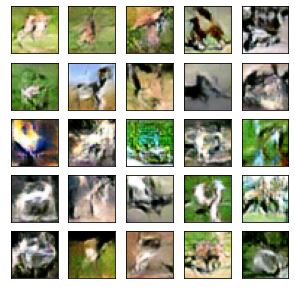

Epoch[42/100],d_loss:-4.594542,g_loss:-9.642464 D real: 31.688696,D fake: 9.642464, Grad_Norm: 0.907585
Epoch[42/100],d_loss:-14.958935,g_loss:27.938618 D real: 2.121828,D fake: -27.938618, Grad_Norm: 0.951562
Epoch[42/100],d_loss:-22.926241,g_loss:34.692638 D real: 9.832421,D fake: -34.692638, Grad_Norm: 1.008124
Epoch[42/100],d_loss:-13.569333,g_loss:28.119171 D real: -2.289373,D fake: -28.119171, Grad_Norm: 0.934583


 43%|████▎     | 43/100 [19:32<26:17, 27.67s/it]

Epoch[43/100],d_loss:-8.984168,g_loss:30.414516 D real: -9.523903,D fake: -30.414516, Grad_Norm: 0.998503
Epoch[43/100],d_loss:-19.938450,g_loss:3.016343 D real: 30.575432,D fake: -3.016343, Grad_Norm: 0.981359
Epoch[43/100],d_loss:-14.147440,g_loss:18.946556 D real: 23.212788,D fake: -18.946556, Grad_Norm: 0.956306
Epoch[43/100],d_loss:-14.508072,g_loss:22.635185 D real: 11.866729,D fake: -22.635185, Grad_Norm: 0.983842


 44%|████▍     | 44/100 [19:59<25:39, 27.49s/it]

Epoch[44/100],d_loss:-20.596638,g_loss:22.884428 D real: 15.830280,D fake: -22.884428, Grad_Norm: 0.981592
Epoch[44/100],d_loss:-18.970486,g_loss:1.028763 D real: 37.307579,D fake: -1.028763, Grad_Norm: 0.991296
Epoch[44/100],d_loss:-13.773032,g_loss:0.940605 D real: 31.895596,D fake: -0.940605, Grad_Norm: 0.994491
Epoch[44/100],d_loss:-11.489414,g_loss:17.388325 D real: 11.579531,D fake: -17.388325, Grad_Norm: 0.975625


 45%|████▌     | 45/100 [20:25<24:51, 27.12s/it]

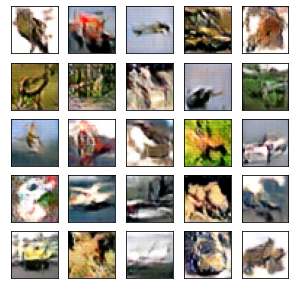

Epoch[45/100],d_loss:-12.244074,g_loss:7.555352 D real: 15.954269,D fake: -7.555352, Grad_Norm: 0.896418
Epoch[45/100],d_loss:-13.953957,g_loss:-7.414209 D real: 35.059956,D fake: 7.414209, Grad_Norm: 0.911066
Epoch[45/100],d_loss:-18.038528,g_loss:16.542511 D real: 15.491352,D fake: -16.542511, Grad_Norm: 0.976201
Epoch[45/100],d_loss:-8.922656,g_loss:26.303753 D real: 10.424580,D fake: -26.303753, Grad_Norm: 0.968356


 46%|████▌     | 46/100 [20:55<25:04, 27.86s/it]

Epoch[46/100],d_loss:-7.941492,g_loss:1.972694 D real: 28.465944,D fake: -1.972694, Grad_Norm: 0.961526
Epoch[46/100],d_loss:-8.759824,g_loss:20.199030 D real: 6.390460,D fake: -20.199030, Grad_Norm: 1.035198
Epoch[46/100],d_loss:-20.986774,g_loss:3.622357 D real: 28.813927,D fake: -3.622357, Grad_Norm: 0.915222
Epoch[46/100],d_loss:-7.668284,g_loss:19.245207 D real: 6.633265,D fake: -19.245207, Grad_Norm: 0.922569


 47%|████▋     | 47/100 [21:22<24:22, 27.59s/it]

Epoch[47/100],d_loss:-10.316672,g_loss:-8.320530 D real: 36.075386,D fake: 8.320530, Grad_Norm: 0.942712
Epoch[47/100],d_loss:-13.112364,g_loss:13.514092 D real: 24.488619,D fake: -13.514092, Grad_Norm: 0.952814
Epoch[47/100],d_loss:-12.376112,g_loss:10.262836 D real: 14.058952,D fake: -10.262836, Grad_Norm: 0.998084
Epoch[47/100],d_loss:-16.214966,g_loss:15.003344 D real: 21.199446,D fake: -15.003344, Grad_Norm: 0.963407


 48%|████▊     | 48/100 [21:50<24:02, 27.75s/it]

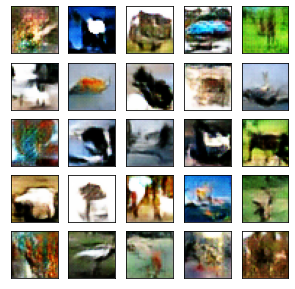

Epoch[48/100],d_loss:-6.650604,g_loss:14.198576 D real: 9.590576,D fake: -14.198576, Grad_Norm: 0.931545
Epoch[48/100],d_loss:-11.118984,g_loss:8.037231 D real: 29.269587,D fake: -8.037231, Grad_Norm: 1.024919
Epoch[48/100],d_loss:-5.545918,g_loss:11.145479 D real: 11.951195,D fake: -11.145479, Grad_Norm: 0.984724
Epoch[48/100],d_loss:-14.341608,g_loss:-1.211571 D real: 32.650188,D fake: 1.211571, Grad_Norm: 1.059163


 49%|████▉     | 49/100 [22:19<23:56, 28.17s/it]

Epoch[49/100],d_loss:-1.361986,g_loss:-17.547300 D real: 44.602413,D fake: 17.547300, Grad_Norm: 0.976504
Epoch[49/100],d_loss:-11.499560,g_loss:30.499069 D real: 2.437831,D fake: -30.499069, Grad_Norm: 0.961765
Epoch[49/100],d_loss:-6.916513,g_loss:14.823715 D real: 19.320892,D fake: -14.823715, Grad_Norm: 1.025199
Epoch[49/100],d_loss:-7.912180,g_loss:-4.211157 D real: 25.024429,D fake: 4.211157, Grad_Norm: 0.892141


 50%|█████     | 50/100 [22:46<23:07, 27.74s/it]

Epoch[50/100],d_loss:-10.812587,g_loss:17.102377 D real: 18.056778,D fake: -17.102377, Grad_Norm: 0.932492
Epoch[50/100],d_loss:-7.968416,g_loss:-8.603401 D real: 37.123695,D fake: 8.603401, Grad_Norm: 0.904938
Epoch[50/100],d_loss:-4.792192,g_loss:11.193914 D real: 17.849854,D fake: -11.193914, Grad_Norm: 0.947116
Epoch[50/100],d_loss:-10.395990,g_loss:-2.161413 D real: 33.046394,D fake: 2.161413, Grad_Norm: 0.921449


 51%|█████     | 51/100 [23:15<23:02, 28.22s/it]

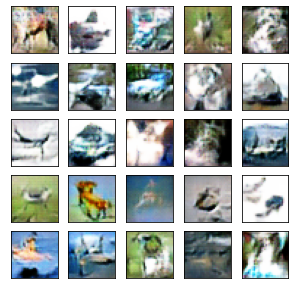

Epoch[51/100],d_loss:-15.949380,g_loss:27.059811 D real: 12.248077,D fake: -27.059811, Grad_Norm: 0.988829
Epoch[51/100],d_loss:-5.718933,g_loss:9.975513 D real: 24.239609,D fake: -9.975513, Grad_Norm: 1.017549
Epoch[51/100],d_loss:-14.549557,g_loss:-6.572032 D real: 27.332069,D fake: 6.572032, Grad_Norm: 0.952644
Epoch[51/100],d_loss:-12.565064,g_loss:-12.414963 D real: 36.168911,D fake: 12.414963, Grad_Norm: 0.949853


 52%|█████▏    | 52/100 [23:44<22:46, 28.47s/it]

Epoch[52/100],d_loss:-10.105425,g_loss:-6.128486 D real: 25.760725,D fake: 6.128486, Grad_Norm: 0.935856
Epoch[52/100],d_loss:-1.695107,g_loss:8.728986 D real: 11.416449,D fake: -8.728986, Grad_Norm: 0.986294
Epoch[52/100],d_loss:-10.632253,g_loss:-12.790081 D real: 39.833549,D fake: 12.790081, Grad_Norm: 0.957473
Epoch[52/100],d_loss:-7.010417,g_loss:-6.237725 D real: 26.974213,D fake: 6.237725, Grad_Norm: 0.982364


 53%|█████▎    | 53/100 [24:11<21:59, 28.07s/it]

Epoch[53/100],d_loss:-6.243357,g_loss:-2.096618 D real: 27.531925,D fake: 2.096618, Grad_Norm: 0.915310
Epoch[53/100],d_loss:-17.596395,g_loss:7.224592 D real: 23.147738,D fake: -7.224592, Grad_Norm: 0.968885
Epoch[53/100],d_loss:-16.501764,g_loss:-10.386333 D real: 43.691013,D fake: 10.386333, Grad_Norm: 0.979634
Epoch[53/100],d_loss:-7.172714,g_loss:0.995444 D real: 30.314035,D fake: -0.995444, Grad_Norm: 0.933713


 54%|█████▍    | 54/100 [24:39<21:33, 28.12s/it]

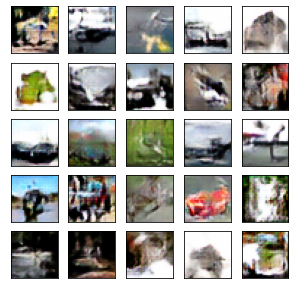

Epoch[54/100],d_loss:-1.620756,g_loss:-7.051629 D real: 27.710707,D fake: 7.051629, Grad_Norm: 0.915880
Epoch[54/100],d_loss:-8.724983,g_loss:-14.316987 D real: 45.828224,D fake: 14.316987, Grad_Norm: 1.034615
Epoch[54/100],d_loss:-15.114840,g_loss:29.898487 D real: 5.820819,D fake: -29.898487, Grad_Norm: 1.099396
Epoch[54/100],d_loss:-8.552832,g_loss:-19.014454 D real: 50.644249,D fake: 19.014454, Grad_Norm: 0.950998


 55%|█████▌    | 55/100 [25:07<21:03, 28.07s/it]

Epoch[55/100],d_loss:-3.550354,g_loss:5.082304 D real: 17.588873,D fake: -5.082304, Grad_Norm: 0.925678
Epoch[55/100],d_loss:-17.763065,g_loss:-3.391504 D real: 40.320499,D fake: 3.391504, Grad_Norm: 0.962765
Epoch[55/100],d_loss:-3.014237,g_loss:-17.457451 D real: 40.908905,D fake: 17.457451, Grad_Norm: 1.011002
Epoch[55/100],d_loss:-14.322004,g_loss:11.381530 D real: 26.123177,D fake: -11.381530, Grad_Norm: 0.962823


 56%|█████▌    | 56/100 [25:34<20:14, 27.60s/it]

Epoch[56/100],d_loss:-2.892220,g_loss:-29.267517 D real: 48.497581,D fake: 29.267517, Grad_Norm: 0.997692
Epoch[56/100],d_loss:-11.670568,g_loss:-20.765816 D real: 44.670132,D fake: 20.765816, Grad_Norm: 0.959657
Epoch[56/100],d_loss:-3.057724,g_loss:-32.902794 D real: 53.853592,D fake: 32.902794, Grad_Norm: 0.903478
Epoch[56/100],d_loss:-0.977265,g_loss:-8.167381 D real: 25.078224,D fake: 8.167381, Grad_Norm: 0.922910


 57%|█████▋    | 57/100 [26:01<19:42, 27.50s/it]

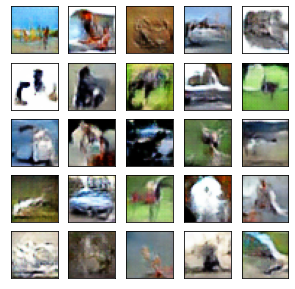

Epoch[57/100],d_loss:-8.710090,g_loss:-14.419827 D real: 37.051796,D fake: 14.419827, Grad_Norm: 0.956052
Epoch[57/100],d_loss:-7.134960,g_loss:-29.548103 D real: 50.621929,D fake: 29.548103, Grad_Norm: 0.894650
Epoch[57/100],d_loss:-7.758984,g_loss:14.063633 D real: 14.150876,D fake: -14.063633, Grad_Norm: 0.980699
Epoch[57/100],d_loss:-11.175633,g_loss:-5.361877 D real: 38.687431,D fake: 5.361877, Grad_Norm: 0.944178


 58%|█████▊    | 58/100 [26:28<19:11, 27.42s/it]

Epoch[58/100],d_loss:-5.127045,g_loss:-13.503019 D real: 35.134766,D fake: 13.503019, Grad_Norm: 0.937182
Epoch[58/100],d_loss:-9.490559,g_loss:-19.609232 D real: 43.942223,D fake: 19.609232, Grad_Norm: 0.970581
Epoch[58/100],d_loss:-4.936856,g_loss:10.898666 D real: 11.427710,D fake: -10.898666, Grad_Norm: 0.939920
Epoch[58/100],d_loss:-1.294749,g_loss:12.976604 D real: 6.200144,D fake: -12.976604, Grad_Norm: 1.003437


 59%|█████▉    | 59/100 [26:55<18:31, 27.10s/it]

Epoch[59/100],d_loss:-3.747804,g_loss:-8.675432 D real: 29.941790,D fake: 8.675432, Grad_Norm: 0.987512
Epoch[59/100],d_loss:-3.029052,g_loss:-1.768690 D real: 29.322138,D fake: 1.768690, Grad_Norm: 0.972434
Epoch[59/100],d_loss:-9.299259,g_loss:-5.288112 D real: 37.433453,D fake: 5.288112, Grad_Norm: 0.960859
Epoch[59/100],d_loss:-2.902535,g_loss:18.108015 D real: -2.296422,D fake: -18.108015, Grad_Norm: 1.013152


 60%|██████    | 60/100 [27:20<17:45, 26.64s/it]

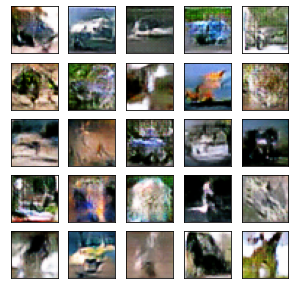

Epoch[60/100],d_loss:-3.862766,g_loss:-14.171731 D real: 33.783302,D fake: 14.171731, Grad_Norm: 0.906191
Epoch[60/100],d_loss:-2.139707,g_loss:-25.534740 D real: 50.758812,D fake: 25.534740, Grad_Norm: 0.909200
Epoch[60/100],d_loss:-10.925220,g_loss:-0.025942 D real: 28.601063,D fake: 0.025942, Grad_Norm: 0.939924
Epoch[60/100],d_loss:-7.173231,g_loss:-12.651869 D real: 36.338760,D fake: 12.651869, Grad_Norm: 0.981624


 61%|██████    | 61/100 [27:48<17:35, 27.08s/it]

Epoch[61/100],d_loss:-4.442130,g_loss:-34.372612 D real: 49.778809,D fake: 34.372612, Grad_Norm: 0.992290
Epoch[61/100],d_loss:-18.590797,g_loss:19.458094 D real: 18.548855,D fake: -19.458094, Grad_Norm: 0.957165
Epoch[61/100],d_loss:-10.821643,g_loss:15.353563 D real: 19.521511,D fake: -15.353563, Grad_Norm: 0.967523
Epoch[61/100],d_loss:-20.215040,g_loss:20.135929 D real: 30.493553,D fake: -20.135929, Grad_Norm: 0.946214


 62%|██████▏   | 62/100 [28:16<17:10, 27.11s/it]

Epoch[62/100],d_loss:-17.386669,g_loss:0.790414 D real: 36.827965,D fake: -0.790414, Grad_Norm: 0.983552
Epoch[62/100],d_loss:-7.382622,g_loss:-10.102291 D real: 38.848930,D fake: 10.102291, Grad_Norm: 0.908561
Epoch[62/100],d_loss:-15.211107,g_loss:14.893866 D real: 30.808651,D fake: -14.893866, Grad_Norm: 1.027096
Epoch[62/100],d_loss:-1.902944,g_loss:-19.625822 D real: 35.328857,D fake: 19.625822, Grad_Norm: 0.951018


 63%|██████▎   | 63/100 [28:42<16:35, 26.92s/it]

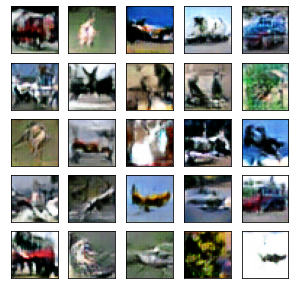

Epoch[63/100],d_loss:-3.014065,g_loss:-3.824783 D real: 23.261894,D fake: 3.824783, Grad_Norm: 1.015257
Epoch[63/100],d_loss:-0.795382,g_loss:-8.829590 D real: 21.156033,D fake: 8.829590, Grad_Norm: 0.950629
Epoch[63/100],d_loss:2.356024,g_loss:-19.253857 D real: 45.482906,D fake: 19.253857, Grad_Norm: 1.001565
Epoch[63/100],d_loss:-7.170898,g_loss:-24.936945 D real: 43.224190,D fake: 24.936945, Grad_Norm: 0.970975


 64%|██████▍   | 64/100 [29:11<16:27, 27.43s/it]

Epoch[64/100],d_loss:-22.334251,g_loss:-22.571775 D real: 59.101749,D fake: 22.571775, Grad_Norm: 0.958122
Epoch[64/100],d_loss:6.906694,g_loss:-46.760017 D real: 74.630180,D fake: 46.760017, Grad_Norm: 0.989174
Epoch[64/100],d_loss:-7.878925,g_loss:-10.268419 D real: 41.676994,D fake: 10.268419, Grad_Norm: 0.875234
Epoch[64/100],d_loss:-6.496639,g_loss:-5.284600 D real: 35.530357,D fake: 5.284600, Grad_Norm: 0.971220


 65%|██████▌   | 65/100 [29:36<15:35, 26.74s/it]

Epoch[65/100],d_loss:-10.398770,g_loss:-17.065344 D real: 45.409351,D fake: 17.065344, Grad_Norm: 0.879793
Epoch[65/100],d_loss:-3.479322,g_loss:-27.210491 D real: 45.774773,D fake: 27.210491, Grad_Norm: 0.943743
Epoch[65/100],d_loss:-1.329680,g_loss:-6.306867 D real: 34.094288,D fake: 6.306867, Grad_Norm: 0.943846
Epoch[65/100],d_loss:-10.725571,g_loss:-11.554171 D real: 36.599003,D fake: 11.554171, Grad_Norm: 0.966394


 66%|██████▌   | 66/100 [30:04<15:18, 27.03s/it]

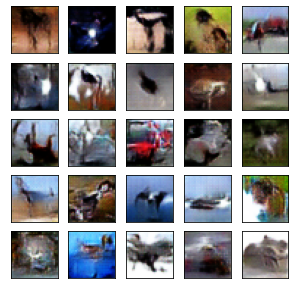

Epoch[66/100],d_loss:-12.035219,g_loss:-16.104996 D real: 45.103622,D fake: 16.104996, Grad_Norm: 0.981928
Epoch[66/100],d_loss:-12.135263,g_loss:-38.019199 D real: 62.513565,D fake: 38.019199, Grad_Norm: 0.969130
Epoch[66/100],d_loss:-13.784650,g_loss:-36.312878 D real: 67.919861,D fake: 36.312878, Grad_Norm: 0.937861
Epoch[66/100],d_loss:-8.224365,g_loss:-9.690565 D real: 34.713165,D fake: 9.690565, Grad_Norm: 0.955519


 67%|██████▋   | 67/100 [30:31<14:53, 27.09s/it]

Epoch[67/100],d_loss:-5.941912,g_loss:-17.662050 D real: 44.834126,D fake: 17.662050, Grad_Norm: 0.919641
Epoch[67/100],d_loss:-11.413790,g_loss:-3.848360 D real: 29.605259,D fake: 3.848360, Grad_Norm: 0.957203
Epoch[67/100],d_loss:-6.217540,g_loss:-42.990261 D real: 63.546589,D fake: 42.990261, Grad_Norm: 0.976405
Epoch[67/100],d_loss:-9.422261,g_loss:-29.569582 D real: 57.482159,D fake: 29.569582, Grad_Norm: 0.888381


 68%|██████▊   | 68/100 [30:57<14:14, 26.70s/it]

Epoch[68/100],d_loss:-8.670404,g_loss:-36.990921 D real: 62.376694,D fake: 36.990921, Grad_Norm: 0.900731
Epoch[68/100],d_loss:-7.771640,g_loss:-43.953491 D real: 65.793152,D fake: 43.953491, Grad_Norm: 0.921260
Epoch[68/100],d_loss:-11.965191,g_loss:-24.114149 D real: 52.252083,D fake: 24.114149, Grad_Norm: 0.942142
Epoch[68/100],d_loss:0.301187,g_loss:-4.999536 D real: 20.316765,D fake: 4.999536, Grad_Norm: 0.950075


 69%|██████▉   | 69/100 [31:23<13:48, 26.72s/it]

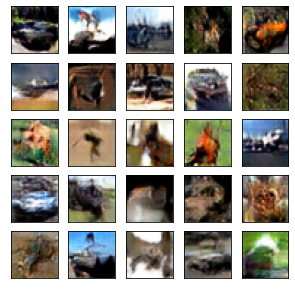

Epoch[69/100],d_loss:-9.409093,g_loss:-8.071562 D real: 31.843435,D fake: 8.071562, Grad_Norm: 0.924245
Epoch[69/100],d_loss:-13.185732,g_loss:-1.727060 D real: 35.543777,D fake: 1.727060, Grad_Norm: 0.957614
Epoch[69/100],d_loss:-11.625862,g_loss:-40.836475 D real: 64.124382,D fake: 40.836475, Grad_Norm: 0.908566
Epoch[69/100],d_loss:-5.986992,g_loss:-15.555227 D real: 37.550869,D fake: 15.555227, Grad_Norm: 0.940931


 70%|███████   | 70/100 [31:53<13:46, 27.56s/it]

Epoch[70/100],d_loss:-13.965567,g_loss:-9.957981 D real: 48.655922,D fake: 9.957981, Grad_Norm: 0.937572
Epoch[70/100],d_loss:-10.821110,g_loss:-6.772677 D real: 42.749496,D fake: 6.772677, Grad_Norm: 0.966076
Epoch[70/100],d_loss:-9.331595,g_loss:-29.938374 D real: 52.491600,D fake: 29.938374, Grad_Norm: 0.972034
Epoch[70/100],d_loss:-11.501004,g_loss:-38.330040 D real: 54.159748,D fake: 38.330040, Grad_Norm: 0.921636


 71%|███████   | 71/100 [32:19<13:09, 27.21s/it]

Epoch[71/100],d_loss:-8.991997,g_loss:-37.962906 D real: 69.342995,D fake: 37.962906, Grad_Norm: 0.952376
Epoch[71/100],d_loss:-11.307693,g_loss:-9.813514 D real: 32.390739,D fake: 9.813514, Grad_Norm: 0.950582
Epoch[71/100],d_loss:-10.906631,g_loss:-32.385750 D real: 60.076881,D fake: 32.385750, Grad_Norm: 0.900556
Epoch[71/100],d_loss:5.792871,g_loss:-12.185450 D real: 27.574797,D fake: 12.185450, Grad_Norm: 0.972561


 72%|███████▏  | 72/100 [32:46<12:34, 26.96s/it]

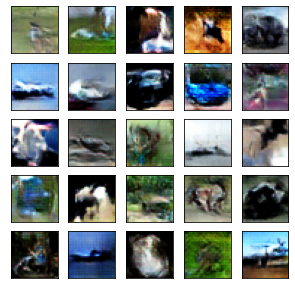

Epoch[72/100],d_loss:-6.717701,g_loss:-22.472237 D real: 53.855846,D fake: 22.472237, Grad_Norm: 0.954813
Epoch[72/100],d_loss:-1.296124,g_loss:-36.371792 D real: 56.717880,D fake: 36.371792, Grad_Norm: 0.915225
Epoch[72/100],d_loss:-10.863687,g_loss:-24.484102 D real: 53.783920,D fake: 24.484102, Grad_Norm: 0.883884
Epoch[72/100],d_loss:-9.334557,g_loss:-38.468155 D real: 58.311989,D fake: 38.468155, Grad_Norm: 0.922448


 73%|███████▎  | 73/100 [33:12<12:02, 26.74s/it]

Epoch[73/100],d_loss:-6.041614,g_loss:-30.511276 D real: 48.691097,D fake: 30.511276, Grad_Norm: 0.906095
Epoch[73/100],d_loss:-3.612877,g_loss:-52.182899 D real: 73.720154,D fake: 52.182899, Grad_Norm: 0.925349
Epoch[73/100],d_loss:-6.160560,g_loss:-30.151392 D real: 58.171917,D fake: 30.151392, Grad_Norm: 0.937854
Epoch[73/100],d_loss:-9.742660,g_loss:-20.052940 D real: 41.582939,D fake: 20.052940, Grad_Norm: 0.918158


 74%|███████▍  | 74/100 [33:37<11:25, 26.36s/it]

Epoch[74/100],d_loss:1.143089,g_loss:-45.758106 D real: 62.532684,D fake: 45.758106, Grad_Norm: 0.904517
Epoch[74/100],d_loss:-3.455768,g_loss:-33.591770 D real: 64.163826,D fake: 33.591770, Grad_Norm: 0.917102
Epoch[74/100],d_loss:-2.424551,g_loss:-12.279218 D real: 41.010010,D fake: 12.279218, Grad_Norm: 0.910518
Epoch[74/100],d_loss:-5.769358,g_loss:-39.033695 D real: 55.658436,D fake: 39.033695, Grad_Norm: 0.935055


 75%|███████▌  | 75/100 [34:07<11:20, 27.22s/it]

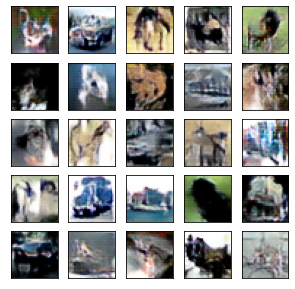

Epoch[75/100],d_loss:-11.250575,g_loss:-18.114008 D real: 46.069118,D fake: 18.114008, Grad_Norm: 0.942720
Epoch[75/100],d_loss:-17.604836,g_loss:-3.705849 D real: 36.435455,D fake: 3.705849, Grad_Norm: 0.988477
Epoch[75/100],d_loss:-8.548483,g_loss:-30.138231 D real: 49.680779,D fake: 30.138231, Grad_Norm: 0.916222
Epoch[75/100],d_loss:3.246592,g_loss:-43.088112 D real: 62.780842,D fake: 43.088112, Grad_Norm: 0.912978


 76%|███████▌  | 76/100 [34:35<11:00, 27.51s/it]

Epoch[76/100],d_loss:-10.237810,g_loss:-18.849758 D real: 44.172173,D fake: 18.849758, Grad_Norm: 0.953633
Epoch[76/100],d_loss:-6.157071,g_loss:-55.810574 D real: 68.193497,D fake: 55.810574, Grad_Norm: 0.954357
Epoch[76/100],d_loss:-13.835488,g_loss:-20.607500 D real: 57.167854,D fake: 20.607500, Grad_Norm: 0.916036
Epoch[76/100],d_loss:-9.711224,g_loss:-20.762127 D real: 43.262642,D fake: 20.762127, Grad_Norm: 0.958521


 77%|███████▋  | 77/100 [35:01<10:27, 27.28s/it]

Epoch[77/100],d_loss:-5.815400,g_loss:-30.990589 D real: 52.326187,D fake: 30.990589, Grad_Norm: 0.948846
Epoch[77/100],d_loss:-12.369510,g_loss:-29.569712 D real: 50.275299,D fake: 29.569712, Grad_Norm: 0.936198
Epoch[77/100],d_loss:-11.064130,g_loss:-44.377899 D real: 65.991997,D fake: 44.377899, Grad_Norm: 0.956491
Epoch[77/100],d_loss:-7.986197,g_loss:-44.114311 D real: 64.312904,D fake: 44.114311, Grad_Norm: 0.875094


 78%|███████▊  | 78/100 [35:29<10:00, 27.29s/it]

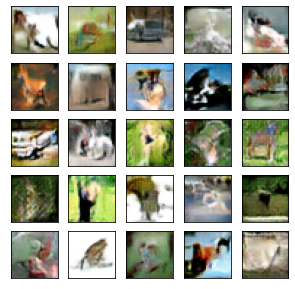

Epoch[78/100],d_loss:-6.951512,g_loss:-30.550938 D real: 58.082142,D fake: 30.550938, Grad_Norm: 0.941082
Epoch[78/100],d_loss:-8.532960,g_loss:-46.172794 D real: 71.507477,D fake: 46.172794, Grad_Norm: 0.892263
Epoch[78/100],d_loss:-8.176052,g_loss:-1.466949 D real: 32.894432,D fake: 1.466949, Grad_Norm: 0.945748
Epoch[78/100],d_loss:-1.635591,g_loss:-29.636574 D real: 50.118729,D fake: 29.636574, Grad_Norm: 0.959319


 79%|███████▉  | 79/100 [36:00<09:55, 28.37s/it]

Epoch[79/100],d_loss:-11.812245,g_loss:-54.658024 D real: 77.901535,D fake: 54.658024, Grad_Norm: 0.917147
Epoch[79/100],d_loss:-3.576924,g_loss:-30.141750 D real: 57.013325,D fake: 30.141750, Grad_Norm: 0.917538
Epoch[79/100],d_loss:-5.842936,g_loss:-31.343403 D real: 48.069965,D fake: 31.343403, Grad_Norm: 0.920654
Epoch[79/100],d_loss:-0.955705,g_loss:-39.229088 D real: 54.270012,D fake: 39.229088, Grad_Norm: 0.931928


 80%|████████  | 80/100 [36:27<09:20, 28.04s/it]

Epoch[80/100],d_loss:-9.641959,g_loss:-44.501419 D real: 70.102554,D fake: 44.501419, Grad_Norm: 0.918324
Epoch[80/100],d_loss:-8.789713,g_loss:-25.467541 D real: 53.430534,D fake: 25.467541, Grad_Norm: 0.916163
Epoch[80/100],d_loss:-14.893738,g_loss:-36.106934 D real: 59.735569,D fake: 36.106934, Grad_Norm: 0.919316
Epoch[80/100],d_loss:-9.968140,g_loss:-39.876797 D real: 60.772854,D fake: 39.876797, Grad_Norm: 0.886360


 81%|████████  | 81/100 [36:53<08:43, 27.54s/it]

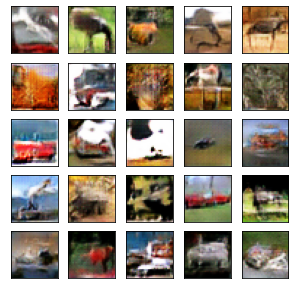

Epoch[81/100],d_loss:-8.237246,g_loss:-55.172089 D real: 79.385742,D fake: 55.172089, Grad_Norm: 0.895187
Epoch[81/100],d_loss:-6.096461,g_loss:-61.083839 D real: 86.341248,D fake: 61.083839, Grad_Norm: 0.962384
Epoch[81/100],d_loss:-8.915916,g_loss:-5.328861 D real: 36.113346,D fake: 5.328861, Grad_Norm: 0.922767
Epoch[81/100],d_loss:-5.612623,g_loss:-55.518917 D real: 83.573517,D fake: 55.518917, Grad_Norm: 0.935172


 82%|████████▏ | 82/100 [37:22<08:22, 27.89s/it]

Epoch[82/100],d_loss:-7.920252,g_loss:-51.867474 D real: 77.334152,D fake: 51.867474, Grad_Norm: 0.936251
Epoch[82/100],d_loss:-3.256991,g_loss:-33.656166 D real: 54.130318,D fake: 33.656166, Grad_Norm: 0.941569
Epoch[82/100],d_loss:-4.925645,g_loss:-40.744629 D real: 61.661148,D fake: 40.744629, Grad_Norm: 0.938951
Epoch[82/100],d_loss:-3.490274,g_loss:-52.450356 D real: 70.246109,D fake: 52.450356, Grad_Norm: 0.958345


 83%|████████▎ | 83/100 [37:50<07:54, 27.90s/it]

Epoch[83/100],d_loss:-5.335632,g_loss:-50.678146 D real: 69.203667,D fake: 50.678146, Grad_Norm: 0.919403
Epoch[83/100],d_loss:-13.476034,g_loss:-39.490505 D real: 59.893089,D fake: 39.490505, Grad_Norm: 0.932971
Epoch[83/100],d_loss:-4.065082,g_loss:-53.174202 D real: 78.652779,D fake: 53.174202, Grad_Norm: 0.941599
Epoch[83/100],d_loss:-7.666864,g_loss:-15.173336 D real: 43.302277,D fake: 15.173336, Grad_Norm: 0.917239


 84%|████████▍ | 84/100 [38:21<07:39, 28.70s/it]

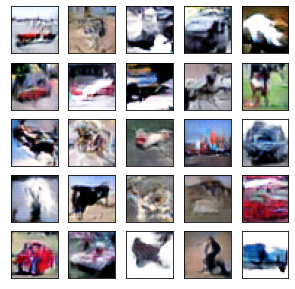

Epoch[84/100],d_loss:-6.590680,g_loss:-65.528603 D real: 93.450790,D fake: 65.528603, Grad_Norm: 0.913828
Epoch[84/100],d_loss:-7.056890,g_loss:-42.279640 D real: 58.926033,D fake: 42.279640, Grad_Norm: 0.966351
Epoch[84/100],d_loss:-2.250095,g_loss:-39.072830 D real: 60.855263,D fake: 39.072830, Grad_Norm: 0.967391
Epoch[84/100],d_loss:-4.188620,g_loss:-43.464298 D real: 65.839447,D fake: 43.464298, Grad_Norm: 0.976588


 85%|████████▌ | 85/100 [38:51<07:19, 29.33s/it]

Epoch[85/100],d_loss:-12.346642,g_loss:-40.487377 D real: 69.984894,D fake: 40.487377, Grad_Norm: 0.924962
Epoch[85/100],d_loss:-9.563797,g_loss:-38.558914 D real: 64.672272,D fake: 38.558914, Grad_Norm: 0.896665
Epoch[85/100],d_loss:-1.925077,g_loss:-57.740540 D real: 77.075073,D fake: 57.740540, Grad_Norm: 0.897061
Epoch[85/100],d_loss:-5.773863,g_loss:-36.731834 D real: 53.951813,D fake: 36.731834, Grad_Norm: 0.959432


 86%|████████▌ | 86/100 [39:19<06:42, 28.77s/it]

Epoch[86/100],d_loss:0.742758,g_loss:-47.289967 D real: 69.310852,D fake: 47.289967, Grad_Norm: 0.952967
Epoch[86/100],d_loss:-4.497220,g_loss:-41.891991 D real: 56.992500,D fake: 41.891991, Grad_Norm: 0.931021
Epoch[86/100],d_loss:-4.707083,g_loss:-57.737541 D real: 82.880020,D fake: 57.737541, Grad_Norm: 0.927227
Epoch[86/100],d_loss:-4.757712,g_loss:-43.165760 D real: 65.726227,D fake: 43.165760, Grad_Norm: 0.945103


 87%|████████▋ | 87/100 [39:47<06:10, 28.49s/it]

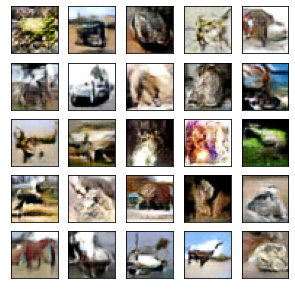

Epoch[87/100],d_loss:-0.255031,g_loss:-34.839539 D real: 55.107929,D fake: 34.839539, Grad_Norm: 0.915801
Epoch[87/100],d_loss:-12.243887,g_loss:-39.587822 D real: 66.886078,D fake: 39.587822, Grad_Norm: 0.923197
Epoch[87/100],d_loss:-7.419504,g_loss:-51.921047 D real: 75.406487,D fake: 51.921047, Grad_Norm: 0.931630
Epoch[87/100],d_loss:-11.926686,g_loss:-30.051210 D real: 58.457291,D fake: 30.051210, Grad_Norm: 0.923867


 88%|████████▊ | 88/100 [40:14<05:38, 28.17s/it]

Epoch[88/100],d_loss:-5.751073,g_loss:-32.367626 D real: 56.059380,D fake: 32.367626, Grad_Norm: 0.924608
Epoch[88/100],d_loss:-11.310858,g_loss:-49.705025 D real: 79.383530,D fake: 49.705025, Grad_Norm: 0.952184
Epoch[88/100],d_loss:0.744237,g_loss:-68.094383 D real: 80.520287,D fake: 68.094383, Grad_Norm: 0.913936
Epoch[88/100],d_loss:4.416904,g_loss:-60.863594 D real: 76.301506,D fake: 60.863594, Grad_Norm: 0.968607


 89%|████████▉ | 89/100 [40:41<05:04, 27.70s/it]

Epoch[89/100],d_loss:-0.000011,g_loss:-50.691246 D real: 66.456932,D fake: 50.691246, Grad_Norm: 0.966955
Epoch[89/100],d_loss:-3.716070,g_loss:-51.886490 D real: 70.579514,D fake: 51.886490, Grad_Norm: 0.936834
Epoch[89/100],d_loss:3.295339,g_loss:-38.923882 D real: 54.023712,D fake: 38.923882, Grad_Norm: 0.883727
Epoch[89/100],d_loss:-5.954259,g_loss:-51.401489 D real: 71.198090,D fake: 51.401489, Grad_Norm: 0.943154


 90%|█████████ | 90/100 [41:07<04:32, 27.22s/it]

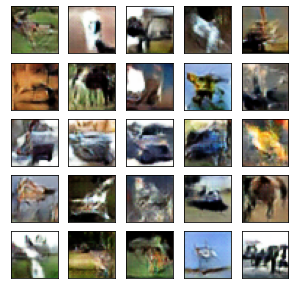

Epoch[90/100],d_loss:0.095744,g_loss:-60.926605 D real: 86.246506,D fake: 60.926605, Grad_Norm: 0.967616
Epoch[90/100],d_loss:2.707254,g_loss:-51.965298 D real: 76.879341,D fake: 51.965298, Grad_Norm: 0.936135
Epoch[90/100],d_loss:-11.873622,g_loss:-44.101334 D real: 68.205124,D fake: 44.101334, Grad_Norm: 0.983088
Epoch[90/100],d_loss:-8.084308,g_loss:-55.371819 D real: 78.899750,D fake: 55.371819, Grad_Norm: 0.924181


 91%|█████████ | 91/100 [41:33<04:02, 26.95s/it]

Epoch[91/100],d_loss:-5.628128,g_loss:-43.762794 D real: 66.192505,D fake: 43.762794, Grad_Norm: 0.949031
Epoch[91/100],d_loss:-4.161180,g_loss:-33.512535 D real: 55.397209,D fake: 33.512535, Grad_Norm: 0.902902
Epoch[91/100],d_loss:-4.207264,g_loss:-56.593559 D real: 76.975708,D fake: 56.593559, Grad_Norm: 0.863492
Epoch[91/100],d_loss:-7.694973,g_loss:-42.627777 D real: 64.662003,D fake: 42.627777, Grad_Norm: 0.946295


 92%|█████████▏| 92/100 [42:03<03:43, 27.94s/it]

Epoch[92/100],d_loss:-11.033093,g_loss:-33.345589 D real: 58.569374,D fake: 33.345589, Grad_Norm: 0.939681
Epoch[92/100],d_loss:-14.082464,g_loss:-65.305634 D real: 92.052162,D fake: 65.305634, Grad_Norm: 0.945234
Epoch[92/100],d_loss:-9.597314,g_loss:-21.697208 D real: 49.748375,D fake: 21.697208, Grad_Norm: 0.923316
Epoch[92/100],d_loss:-0.331751,g_loss:-69.594421 D real: 91.971840,D fake: 69.594421, Grad_Norm: 0.917558


 93%|█████████▎| 93/100 [42:31<03:15, 27.94s/it]

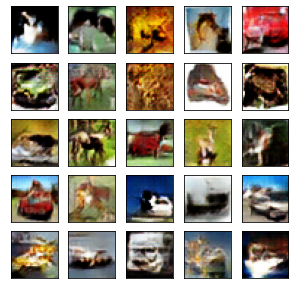

Epoch[93/100],d_loss:-4.966030,g_loss:-51.073837 D real: 74.967964,D fake: 51.073837, Grad_Norm: 0.896016
Epoch[93/100],d_loss:-4.117137,g_loss:-49.880367 D real: 67.535934,D fake: 49.880367, Grad_Norm: 0.912037
Epoch[93/100],d_loss:-0.967473,g_loss:-73.007233 D real: 88.458336,D fake: 73.007233, Grad_Norm: 0.921826
Epoch[93/100],d_loss:-3.768595,g_loss:-69.174774 D real: 83.960861,D fake: 69.174774, Grad_Norm: 0.981215


 94%|█████████▍| 94/100 [43:00<02:49, 28.24s/it]

Epoch[94/100],d_loss:-6.930747,g_loss:-73.561134 D real: 88.274391,D fake: 73.561134, Grad_Norm: 0.959954
Epoch[94/100],d_loss:-16.935780,g_loss:-44.425835 D real: 69.506332,D fake: 44.425835, Grad_Norm: 0.905241
Epoch[94/100],d_loss:-11.678644,g_loss:-78.677994 D real: 101.307968,D fake: 78.677994, Grad_Norm: 0.932866
Epoch[94/100],d_loss:-1.366844,g_loss:-70.753792 D real: 91.756737,D fake: 70.753792, Grad_Norm: 0.917248


 95%|█████████▌| 95/100 [43:29<02:22, 28.41s/it]

Epoch[95/100],d_loss:-1.231853,g_loss:-59.322445 D real: 79.809906,D fake: 59.322445, Grad_Norm: 0.964536
Epoch[95/100],d_loss:-2.617524,g_loss:-80.949318 D real: 95.302689,D fake: 80.949318, Grad_Norm: 0.964820
Epoch[95/100],d_loss:3.237908,g_loss:-47.390350 D real: 58.269939,D fake: 47.390350, Grad_Norm: 0.945523
Epoch[95/100],d_loss:-14.728934,g_loss:-91.201691 D real: 125.042816,D fake: 91.201691, Grad_Norm: 1.003553


 96%|█████████▌| 96/100 [43:55<01:50, 27.64s/it]

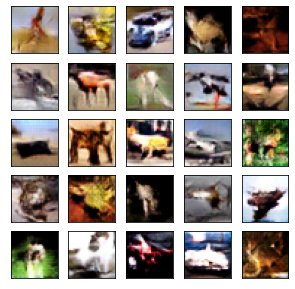

Epoch[96/100],d_loss:0.961997,g_loss:-73.923340 D real: 92.747581,D fake: 73.923340, Grad_Norm: 0.902314
Epoch[96/100],d_loss:-10.616219,g_loss:-70.988708 D real: 92.740440,D fake: 70.988708, Grad_Norm: 0.969538
Epoch[96/100],d_loss:-1.029013,g_loss:-53.856316 D real: 66.735107,D fake: 53.856316, Grad_Norm: 0.915245
Epoch[96/100],d_loss:-6.395439,g_loss:-53.850212 D real: 78.754990,D fake: 53.850212, Grad_Norm: 0.877151


 97%|█████████▋| 97/100 [44:25<01:25, 28.37s/it]

Epoch[97/100],d_loss:-10.634423,g_loss:-64.632484 D real: 86.980972,D fake: 64.632484, Grad_Norm: 0.952220
Epoch[97/100],d_loss:-5.819255,g_loss:-35.325592 D real: 58.818108,D fake: 35.325592, Grad_Norm: 0.910265
Epoch[97/100],d_loss:-6.351820,g_loss:-82.400085 D real: 99.506851,D fake: 82.400085, Grad_Norm: 0.946482
Epoch[97/100],d_loss:-9.551638,g_loss:-45.412064 D real: 71.104446,D fake: 45.412064, Grad_Norm: 0.915261


 98%|█████████▊| 98/100 [44:53<00:56, 28.32s/it]

Epoch[98/100],d_loss:-8.827565,g_loss:-51.335262 D real: 76.648880,D fake: 51.335262, Grad_Norm: 0.961885
Epoch[98/100],d_loss:-3.765660,g_loss:-69.850677 D real: 84.223007,D fake: 69.850677, Grad_Norm: 0.916868
Epoch[98/100],d_loss:-0.642882,g_loss:-56.848724 D real: 69.273491,D fake: 56.848724, Grad_Norm: 0.901246
Epoch[98/100],d_loss:2.090133,g_loss:-45.788155 D real: 53.352417,D fake: 45.788155, Grad_Norm: 0.921246


 99%|█████████▉| 99/100 [45:21<00:28, 28.13s/it]

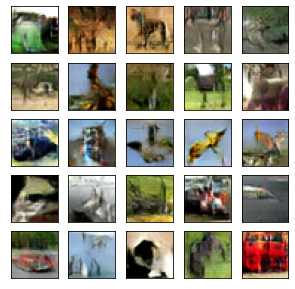

Epoch[99/100],d_loss:-4.925494,g_loss:-59.348274 D real: 78.410156,D fake: 59.348274, Grad_Norm: 0.907453
Epoch[99/100],d_loss:1.019672,g_loss:-61.341118 D real: 76.964462,D fake: 61.341118, Grad_Norm: 0.949186
Epoch[99/100],d_loss:-7.340641,g_loss:-59.329967 D real: 80.994537,D fake: 59.329967, Grad_Norm: 0.916408
Epoch[99/100],d_loss:-13.420455,g_loss:-44.448040 D real: 73.587212,D fake: 44.448040, Grad_Norm: 0.906380


100%|██████████| 100/100 [45:51<00:00, 27.52s/it]


"    if epoch == 0:\n        real_images = inv_normalize(real_img.cpu().data)\n        save_image(real_images, '../../img/real_images.png')\n \n    fake_images = inv_normalize(fake_img.cpu().data)\n    save_image(fake_images, '../../img/fake_images-{}.png'.format(epoch+1))"

In [10]:
G_losses = []
D_losses = []

for epoch in tqdm(range(num_epoch)):
    if epoch % 3 == 0:
        G.eval()
        z = torch.randn(25, z_dim,1,1).to(device)
        img = G(z)
        plt.close()
        grid_size, k = int(img.shape[0] ** 0.5), 0 # 10 * 10
        fig, ax = plt.subplots(grid_size, grid_size, figsize=(5, 5))
        for i, j in product(range(grid_size), range(grid_size)): # to draw 10 * 10 images
            ax[i,j].get_xaxis().set_visible(False)
            ax[i,j].get_yaxis().set_visible(False)
            ax[i,j].imshow((inv_normalize(img[k]) * 255).data.cpu().numpy().transpose((1,2,0)).astype(np.uint8))
            k += 1
        plt.show()
        
    for i, (img, _) in enumerate(dataloader): # Since we don't need any labels, we make label be '_'

        # =============================== IMAGES =================================
        num_img = img.size(0) 
        #img = img.view(num_img, -1) # view()函数作用是将一个多行的Tensor,拼接成一行
                                    # 第一个参数是要拼接的tensor,第二个参数是-1
        # After view(), the input image will be a vector as 28 * 28 = 782 dimensions
        real_img = img.to(device) # the sampled data are real images


        # ========================= D: Forward and Loss ==========================
        # D_loss: wasserstein loss for discriminator,
        # -E[D(x)] + E[D(G(z))] + λE[(||∇ D(εx + (1 − εG(z)))|| - 1)^2]
        real_out = D(real_img).view(-1,1)
        
        z = torch.randn(num_img, z_dim, 1, 1).to(device)
        fake_img = G(z)
        fake_out = D(fake_img).view(-1,1)
        
        # GRADIENT PENALTY:
        # Uniformly sample along one straight line per each batch entry.
        epsilon = torch.rand(real_img.shape[0], 1).view(-1,1,1,1).to(device)
        # Generate images from the noise, ensure unit gradient norm 1
        # See Section 4 and Algorithm 1 of original paper for full explanation.
        G_interpolation = epsilon*real_img + (1-epsilon)*fake_img
        D_interpolation = D(G_interpolation)
        # Compute the gradients of D with respect to the noise generated input
        weight = torch.ones(D_interpolation.size()).to(device)
        gradients = torch.autograd.grad(outputs=D_interpolation,
                                        inputs=G_interpolation,
                                        grad_outputs=weight,
                                        only_inputs=True,
                                        create_graph=True,
                                        retain_graph=True)[0]
        # Full gradient penalty
        grad_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
        
        # Compute WGAN-GP loss for D
        d_loss = torch.mean(fake_out) - torch.mean(real_out) + grad_penalty
        
        d_optimizer.zero_grad() # before back propagation
        d_loss.backward()
        d_optimizer.step()
        D_losses.append(d_loss)

        # =============== G ========================
        #G_loss: wasserstein loss for generator, -E[D(G(z))]
        z = torch.randn(num_img, z_dim, 1, 1).to(device)
        # z = torch.randn(num_img, z_dim, 1, 1)

        fake_img = G(z)
        fake_out = D(fake_img).view(-1,1)
        g_loss = -1 * (torch.mean(fake_out))

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        G_losses.append(g_loss)
        # ============= Visualization ===============
        if i%100 == 0:
            print('Epoch[{}/{}],d_loss:{:.6f},g_loss:{:.6f} '
                  'D real: {:.6f},D fake: {:.6f}, Grad_Norm: {:.6f}'.format(
                epoch,num_epoch,d_loss.item(),g_loss.item(),
                real_out.data.mean(),fake_out.data.mean(), gradients.norm(2, dim=1).mean() #打印的是真实图片的损失均值
            ))
        
'''    if epoch == 0:
        real_images = inv_normalize(real_img.cpu().data)
        save_image(real_images, '../../img/real_images.png')
 
    fake_images = inv_normalize(fake_img.cpu().data)
    save_image(fake_images, '../../img/fake_images-{}.png'.format(epoch+1))'''

# Visualization

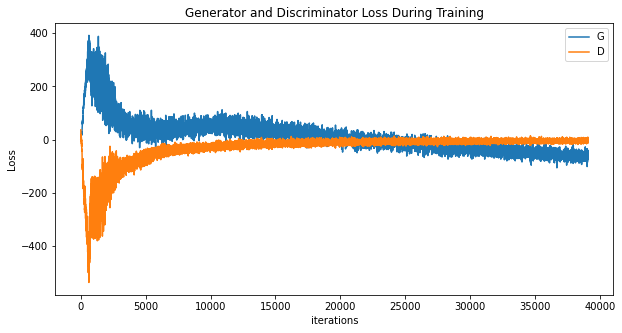

In [11]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Debug 专区

SyntaxError: invalid syntax (<ipython-input-12-abefa8d9bb1a>, line 1)

In [ ]:
.expand(real_img.size())